In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import entropy, variation

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins, nbrh_WG_open
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
dico_garden_opening_hour = config.dico_garden_opening_hour
id_run = config.id_run
mindur_toaccountforZ4 = config.mindur_toaccountforZ4
dico_matching = config.dico_matching
print(id_run)

change the configuration file if not done yet!
ALLDATA_


# Download data

In [4]:
#cleaned mvt data
df_init = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date']) 
print(df_init.shape)
df_init.head(3)

(2681720, 18)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,duration,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,duration_mn,is_day
0,hen_1,pen9,8 - 9,2_Zone,1.0,2020-09-29 09:50:00,2020-09-29,2020-09-29 17:56:25,0 days 08:06:25,NaN,NaN,3_Zone,NaN,NaN,False,False,486.416667,True
1,hen_1,pen9,8 - 9,3_Zone,1.0,2020-09-29 17:56:25,2020-09-29,2020-09-30 09:55:59,0 days 02:52:35,2020-09-29 09:50:00,0 days 08:06:25,3_Zone,2_Zone,NaN,False,False,959.566667,False
2,hen_1,pen9,8 - 9,5_Zone,1.0,2020-09-30 09:55:59,2020-09-30,2020-09-30 11:34:30,0 days 01:32:11,2020-09-30 09:51:57,0 days 00:04:02,5_Zone,3_Zone,3_Zone,False,False,98.516667,True


In [5]:
#daily var
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
df_daily = df_daily[df_daily['level']!=dt.datetime(2021,7,25)]
print(df_daily.shape)
df_daily.head(3)

(38694, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


#daily var IN BETWEEN CHECKS
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily__pen12_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
print(df_daily.shape)
df_daily.head(3)

In [6]:
print(df_daily[df_daily['vertical_travel_distance_dawn']==0].shape)
print(df_daily[df_daily['vertical_travel_distance_dawn']>0].shape)

(32658, 70)
(298, 70)


In [7]:
df_daily[['list_Z4','mid_cum_Z4_sec','list_of_zones','list_of_durations']]

,list_Z4,mid_cum_Z4_sec,list_of_zones,list_of_durations
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,['5_Zone'],[32400.0]
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1474.0,"['5_Zone', '3_Zone', '4_Zone', '5_Zone']","[532.0, 780.0, 325.0, 30763.0]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",520.0,"['3_Zone', '2_Zone', '3_Zone', '4_Zone', '5_Zo...","[225.0, 206.0, 24.0, 130.0, 31815.0]"
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"['3_Zone', '2_Zone', '3_Zone', '2_Zone', '3_Zo...","[1059.0, 13499.0, 1854.0, 9057.0, 1502.0, 1829.0]"
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"['2_Zone', '3_Zone', '2_Zone', '3_Zone', '5_Zo...","[4325.0, 2707.0, 7088.0, 1977.0, 3930.0, 7170...."
...,...,...,...,...
38689,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",15088.0,"['4_Zone', '3_Zone', '4_Zone', '3_Zone', '2_Zo...","[676.0, 45.0, 9.0, 4.0, 1088.0, 31.0, 107.0, 5..."
38690,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13686.0,"['3_Zone', '4_Zone', '3_Zone', '2_Zone', '3_Zo...","[719.0, 129.0, 69.0, 1056.0, 201.0, 27.0, 590...."
38691,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13768.0,"['4_Zone', '3_Zone', '4_Zone', '3_Zone', '2_Zo...","[746.0, 26.0, 46.0, 83.0, 1054.0, 268.0, 735.0..."
38692,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13599.0,"['4_Zone', '3_Zone', '2_Zone', '3_Zone', '2_Zo...","[730.0, 184.0, 1089.0, 182.0, 399.0, 78.0, 156..."


In [8]:
print(list(df_daily.columns))

['HenID', 'level', 'duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'dur_values_normalized', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen', 'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone', 'list_of_durations', 'food_related_behavior', 'food_related_behavior_rp', 'food_related_behavior_rm', 'food_related_behavior4', 'food_related_behavior_rp4', 'food_related_behavior_rm4', 'nestboxes_related_behavior', 'list_of_zones', 'list_Z4', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'vertical_travel_dis

# Transformation - Could be added in UTILS if another run

In [9]:
#add tracking system ID
df_daily['TrackingSystemID'] = df_daily['PenID'].map(lambda x: config.dico_pen_ts[x])
display(df_daily['TrackingSystemID'].value_counts())

TrackingSystem 10-12    14847
TrackingSystem 3-5      14076
TrackingSystem 8-9       9771
Name: TrackingSystemID, dtype: int64

In [10]:
#add if animal is sleeping up 
df_daily['Is_Sleeping_UP'] = df_daily['night_Max_duration_zones'].isin(['5_Zone','4_Zone'])
display(df_daily['Is_Sleeping_UP'].value_counts(normalize=True))
#better than binary: height of sleeping
print(df_daily.shape)
df_daily = df_daily[~df_daily['night_Max_duration_zones'].isnull()]
df_daily['SleepingHeight'] = df_daily['night_Max_duration_zones'].map(lambda x: int(x.split('_')[0])-2)#-2: litter (zon2: equal to 0 tiers underneath)
display(df_daily['SleepingHeight'].value_counts(normalize=True))

True     0.821523
False    0.178477
Name: Is_Sleeping_UP, dtype: float64

(38694, 72)


3    0.694429
1    0.164954
2    0.136564
0    0.004052
Name: SleepingHeight, dtype: float64

#nbr transitions per hour. 
#df_daily['nbr_h_WGopen'] = df_daily['level'].map(lambda x: nbrh_WG_open(x, config))
li_ = ['vertical_travel_distance','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
for v in li_:
    df_daily[v+'_perh'] = df_daily.apply(lambda x: x[v]/x['nbr_h_per_day'], axis=1)
    df_daily['nbr_stays_1_Zone_perh'] = df_daily.apply(lambda x: x['nbr_stays_1_Zone']/x['nbr_h_WGopen'] if x['nbr_h_WGopen']!=0 else np.nan, axis=1)
df_daily[['vertical_travel_distance_perh','vertical_travel_distance', 'nbr_stays_3_Zone', 'nbr_stays_3_Zone_perh',
        'nbr_h_per_day']].tail(3)

#uncommon/extreme behavior
df_daily['uncommon_behavior'] = df_daily.apply(lambda x: sum([x['Total_number_zone']<=2])>=1, axis=1)
display(df_daily[df_daily['level']>dt.datetime(2020,11,10)]['uncommon_behavior'].value_counts(normalize=True))
df_daily[(df_daily['uncommon_behavior']>0)&(df_daily['level']>dt.datetime(2020,11,10))][['level','HenID','uncommon_behavior','SleepingHeight','nestboxes_related_behavior',
                                           'Total_number_zone']].head(5)

#uncommon/extreme behavior
df_daily['uncommon_behavior'] = df_daily.apply(lambda x: sum([x['SleepingHeight'] in [0,1], 
                                                              x['nestboxes_related_behavior']<0,
                                                              x['Total_number_zone']<=2,
                                                              x['duration_4_Zone']<15*60])>=1, axis=1)
display(df_daily[df_daily['level']>dt.datetime(2020,11,10)]['uncommon_behavior'].value_counts(normalize=True))
df_daily[(df_daily['uncommon_behavior']>0)&(df_daily['level']>dt.datetime(2020,11,10))][['level','HenID','uncommon_behavior','SleepingHeight','nestboxes_related_behavior',
                                           'Total_number_zone']].head(5)

,list_Z4,mid_cum_Z4_sec,nbr_h_per_day,time_midduratioZ4_h
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,9,NaN
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1474.0,9,NaN
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",520.0,9,NaN


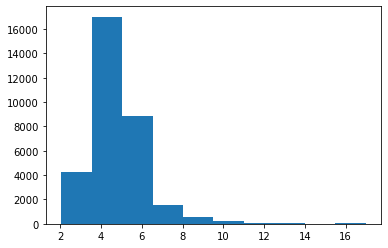

In [11]:
#only since 2h start in the morning
df_daily['time_midduratioZ4_h'] = df_daily['mid_cum_Z4_sec'].map(lambda x: x/60/60+2)
df_daily.loc[df_daily['level']<dt.datetime(2020,11,13,0,0,0),'time_midduratioZ4_h'] = np.nan
plt.hist(df_daily['time_midduratioZ4_h']);
df_daily[['list_Z4', 'mid_cum_Z4_sec','nbr_h_per_day','time_midduratioZ4_h']].head(3)

In [12]:
def mid_cum_Z4_sec(li_Z4):
    li = list(np.cumsum(li_Z4))
    m = int(max(li)/2) #round down 
    if m>0:
        ind_ = li.index(m) + 1 #+1 for index 0
        return(ind_)
    #if never went in nestboxes then put np.nan
    return np.nan
#small example
li = [1,1,4,4,4,1,1,2,2,2,3,3,3,1,4,2,2,2,2,5,5,5,4,4,4]
li = [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
mid_cum_Z4_sec(li) #5

5

In [13]:
def nbr_early_visit_Z4(li):
    li_z = [x[0] for x in itertools.groupby(li)]
    return (sum(li_z))
#small example
li = [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
nbr_early_visit_Z4(li) #[1, 2, 3, 4, 2, 4, 1, 2]

def nbr_early_visit_Z4_moreXsec(li, mindur_toaccountforZ4):
    #add 0 in the list in case it starts with 1
    li = [0]+li
    #print('_'.join([str(i) for i in li]))
    #print('_'.join([str(i) for i in li]).split('0_1'))
    #split each time hen visited the nestbox and sum each of those instances adding 1 , but removing first element, as its only 0
    li_dur = [j.count("1")+1 for j in '_'.join([str(i) for i in li]).split('0_1')[1:]] 
    return(len([i for i in li_dur if i>=mindur_toaccountforZ4]))
#small example
li = [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1] #3
li = [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1] #4
nbr_early_visit_Z4_moreXsec(li, mindur_toaccountforZ4=2) #[1, 2, 3, 4, 2, 4, 1, 2]

4

(array([2.8127e+04, 8.1580e+03, 1.5040e+03, 3.1600e+02, 9.8000e+01,
        3.4000e+01, 8.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <BarContainer object of 10 artists>)

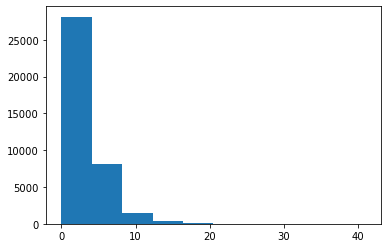

In [14]:
df_daily['nbr_visit_Z4_Morning'] = df_daily['list_Z4'].map(lambda x: nbr_early_visit_Z4(eval(x)[0:((8-2)*60*60)]))
plt.hist(df_daily['nbr_visit_Z4_Morning']);

In [ ]:
df_daily['nbr_visit_Z4_Morning_more'+str(mindur_toaccountforZ4)+'sec'] = df_daily['list_Z4'].map(lambda x: nbr_early_visit_Z4_moreXsec(eval(x)[0:((8-2)*60*60)],
                                                                                                           mindur_toaccountforZ4))
plt.hist(df_daily['nbr_visit_Z4_Morning_more'+str(mindur_toaccountforZ4)+'sec'])

In [ ]:
df_daily['nbr_visit_Z4_Morning_more15sec']

In [ ]:
len(eval(df_daily['list_Z4'].iloc[1]))/60/60

In [ ]:
len(eval(df_daily['list_Z4'].iloc[1])[0:((8-2)*60*60)])/60/60

In [ ]:
#df_daily[''] = df_daily['list_Z4'].map(lambda x: eval(x)[0:((8-2)*60*60)])
df_daily['mid_cum_Z4_sec_Morning'] = df_daily['list_Z4'].map(lambda x: mid_cum_Z4_sec(eval(x)[0:((8-2)*60*60)]))
df_daily['duration_until8_inZ4'] = df_daily['list_Z4'].map(lambda x: sum(eval(x)[0:((8-2)*60*60)]))
#nan before the light start at 2h!
df_daily.loc[df_daily['level']<dt.datetime(2020,11,13,0,0,0),'mid_cum_Z4_sec_Morning'] = np.nan
df_daily['mid_cum_Z4_h_Morning'] = df_daily['mid_cum_Z4_sec_Morning'].map(lambda x: x/60/60+2)

In [ ]:
plt.hist(df_daily[(df_daily['level']>dt.datetime(2020,11,13))]['mid_cum_Z4_h_Morning']);

In [ ]:
plt.hist(df_daily[(df_daily['level']>dt.datetime(2020,11,13))]['nbr_visit_Z4_Morning']);

In [ ]:
plt.hist(df_daily[(df_daily['level']>dt.datetime(2020,11,13))]['nbr_visit_Z4_Morning_more'+str(mindur_toaccountforZ4)+'sec']);

In [ ]:
df_plt = df_daily.groupby(['HenID'])[['nbr_visit_Z4_Morning','mid_cum_Z4_h_Morning']].mean().reset_index()
print(df_plt.shape)
display(df_plt.head(3))
plt.scatter(df_plt['nbr_visit_Z4_Morning'].tolist(), df_plt['mid_cum_Z4_h_Morning'].tolist());

In [ ]:
plt.hist(df_daily['duration_until8_inZ4']);

In [ ]:
df_daily[(df_daily['level']>dt.datetime(2020,11,13))&(df_daily['duration_until8_inZ4']<15*60)][['duration_until8_inZ4',
                                                                                                   'HenID','level',
                                                                                                   'mid_cum_Z4_h_Morning',
                                                                                               'nbr_visit_Z4_Morning']]

In [ ]:
df_daily.shape

In [ ]:
586/38253*100

In [ ]:
10*60*60

### add vertical distance full light and /inside hour

In [ ]:
#add vertical travel distance during full light
df_daily['vertical_travel_distance_fulllight'] = df_daily.apply(lambda x: x['vertical_travel_distance']-x['vertical_travel_distance_dusk'], axis=1)
#we substract the dusk timing:
li_light_dusk_ = config.li_light_dusk_
nbr_dusk_sec = (max(li_light_dusk_)-min(li_light_dusk_)).seconds
print('dusk phase lasted for %d minutes' %(nbr_dusk_sec/60))
df_daily['vertical_travel_distance_fulllight_perinsideh'] = df_daily.apply(lambda x: x['vertical_travel_distance_fulllight']/(15-(x['duration_1_Zone']+nbr_dusk_sec)/60/60),axis=1)

### add order of going to the litter in the morning

#sorted so that smallest comes first
dico_level_sortedlistdate = dict(df_daily.groupby(['level','PenID'])['FirstTimestamp_2_Zone'].agg(lambda x: sorted([i for i in list(x) if i is not pd.NaT])))
df_daily['order_firstlitter'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['FirstTimestamp_2_Zone']) if x['FirstTimestamp_2_Zone'] is not pd.NaT else np.nan, axis=1)
df_daily['order_firstlitter_percent'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['FirstTimestamp_2_Zone'])/\
                                           len(dico_level_sortedlistdate[(x['level'],x['PenID'])]) if x['FirstTimestamp_2_Zone'] is not pd.NaT else np.nan, axis=1)

#small verification
df_daily[df_daily['PenID']==10][['order_firstlitter','order_firstlitter_percent','FirstTimestamp_2_Zone','level','PenID',
                                 'HenID']].sort_values(['FirstTimestamp_2_Zone'])

#verify that when an animal slept in the litter then its the first animal to be in litter.
#find such instance (i.e. the day after sleeping height=0!)
display(df_daily[(df_daily['SleepingHeight']==0)&(df_daily['PenID']==10)][['order_firstlitter','order_firstlitter_percent',
                                                                   'FirstTimestamp_2_Zone','level','PenID','HenID',
                                                                   'SleepingHeight']])
df_daily[(df_daily['level'].isin([dt.datetime(2020,10,6),dt.datetime(2020,10,16),dt.datetime(2020,10,22),
                                  dt.datetime(2020,10,28)]))&(df_daily['HenID']=='hen_143')][['order_firstlitter','order_firstlitter_percent',
                                                                   'FirstTimestamp_2_Zone','level','PenID','HenID',
                                                                   'SleepingHeight']]
#correct!

### add order of going to the top floor in the evening

#compute last timestamp:
#why: will be usefull to produce other variables, to verify the code and to use it for some zones
df_ = df_init[df_init['Zone']=='5_Zone'].groupby(['HenID', 'date'])['Timestamp'].agg(lambda x: max(list(x))).reset_index()
df_.rename(columns={'Timestamp':'LastTimestampToptier','date':'level'}, inplace=True)
display(df_)
df_daily = pd.merge(df_daily, df_, how='left', on=['HenID','level'])

#ATTENTION: LastTimestampToptier does not mean that the bird stayed there after!! so have to be combined with their sleeping height
#Note that if the hen arrived up at 16h59, but then was kikked away at 17h01: we dont care as long as its sleeping height is the top floor.
#sorted so that smallest comes first
dico_level_sortedlistdate = dict(df_daily.groupby(['level','PenID'])['LastTimestampToptier'].agg(lambda x: sorted([i for i in list(x) if i is not pd.NaT])))
df_daily['order_firstgoingup'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['LastTimestampToptier']) if x['LastTimestampToptier'] is not pd.NaT else np.nan, axis=1)
df_daily['order_firstgoingup_percent'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['LastTimestampToptier'])/\
                                           len(dico_level_sortedlistdate[(x['level'],x['PenID'])]) if x['LastTimestampToptier'] is not pd.NaT else np.nan, axis=1)
df_daily['LastTimestampToptier_time'] = df_daily['LastTimestampToptier'].map(lambda x: dt.datetime.time(x))
#small verification
df_daily[df_daily['PenID']==10][['order_firstgoingup','order_firstgoingup_percent','LastTimestampToptier','LastTimestampToptier_time',
                                 'level','PenID','HenID','SleepingHeight']].sort_values(['LastTimestampToptier'])
#ISSUE: might not be there anymore!!! should be done with ts!!!!! but then waht if an animal arrive when its dark? bold or not?

#would be 0 if they did not slept up, 1 would mean and 
#in that case, the bird that went up at 6h30 or the one that did not slept in top tier have the save value:30
df_daily['lastminutessleepingUP'] = df_daily.apply(lambda x: x['SleepingHeight']==3 & x['LastTimestampToptier'], axis=1)

#(day_Z5 /day – night_Z5/night) / (day_Z5 /day + night_Z5/night)
def Z5_diurnality(dur_day, dur_night, nbr_h_per_day):
    n = dur_day/nbr_h_per_day - dur_night/(24-nbr_h_per_day)
    p = dur_day/nbr_h_per_day + dur_night/(24-nbr_h_per_day)
    #if never spent time in Z5 then return: neutral nght versus day behavior
    if p==0:
        return 0
    return n/p  

df_daily['Z5diuranility'] = df_daily.apply(lambda x: Z5_diurnality(dur_day=x['duration_5_Zone'],
                                                                   dur_night=x['night_duration_Z5'],
                                                                   nbr_h_per_day=x['nbr_h_per_day']), axis=1)
plt.hist(df_daily['Z5diuranility']);
df_daily[['night_duration_Z5','duration_5_Zone','Z5diuranility']].tail(5)

#coefficient of variation: ratio of standard deviation to mean. np.std(x) / np.mean(x)
df_daily['CVduration'] = df_daily['list_of_durations'].map(lambda x: variation(eval(x)))
display(df_daily[df_daily['CVduration'].isnull()])
df_daily[['list_of_durations','list_of_zones','latency_1_Zone_h','latency_4_Zone_h','latency_2_Zone_h','CVduration']]
plt.hist(df_daily['CVduration']);

# Add daily HA using interpolation

In [ ]:
#KBF&severity
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_HA['FeatherDamage'] = df_HA['Feathers'].map(lambda x: 100-x)
df_HA['date_HA'] = df_HA['date'].copy()
df_HA = df_HA[~df_HA['HenID'].isnull()] #two isntances
print(df_HA.shape)
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
display(df_HA['HAID'].value_counts())
#info on date
display(df_HA.groupby(['HAID','date','WOA','DOA'])['HenID'].count().reset_index())
print(df_HA.shape)
df_HA.head(3)

In [ ]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

In [ ]:
def inter_HA(HenID, DOA, df_HA, df_FB, str_ha):
    if str_ha not in df_HA.columns:
        print('error, specify an exist column name')
        sys.exit()
    #available HA days, for that specific hen
    li_DOA = np.array(df_HA[(df_HA['HenID']==HenID)&(~df_HA[str_ha].isnull())]['DOA'].unique())
    if len(li_DOA)==0:
        return np.nan
    mi = min(li_DOA)
    ma = max(li_DOA)
        
    #if its an exact date (never happen, except for last date, which we put to be the date previous the real HA)
    if DOA in li_DOA:
        return df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==DOA)][str_ha].iloc[0]
    
    #if its at the lower boundery, then add the timestamp 0 when they moved to the laying barn
    #(if its at the higher boundery, then add the KBF from that time (but this should never happend))
    #we wont allow a to big difference either
    #the day previous can be assumed as the same as the actual health measured ont eh day after
    if (DOA<mi) & (mi-DOA==1):
        x1 = 119
        wdoa119 = df_FB[df_FB['HenID']==HenID]['29-09 weight'].iloc[0]
        x2 = li_DOA[li_DOA > DOA].min() #smallest above 
        #we actually only allows this when the highiest above is HA 1, i.e. 173 DOA
        if x2==173:
            return(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==mi)][str_ha].iloc[0])        

    if (DOA<mi) & (str_ha=='weight'):
        x1 = 119
        wdoa119 = df_FB[df_FB['HenID']==HenID]['29-09 weight'].iloc[0]
        x2 = li_DOA[li_DOA > DOA].min() #smallest above 
        #we actually only allows this when the highiest above is HA 1, i.e. 173 DOA
        if x2==173:
            return(np.interp(DOA, xp=(x1,x2), fp=(wdoa119, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))        
    if (DOA<mi) & (str_ha=='FeatherDamage'):
        fdoa119 = 0 #assume 0 for all when transfer to LB
        x1 = 119
        x2 = li_DOA[li_DOA > DOA].min() #smallest above
        #we actually only allows this when the highiest above is HA 1, i.e. 173 DOA
        if x2==173:
            return(np.interp(DOA, xp=(x1,x2), fp=(0, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))        
    if DOA<mi:
        #print(DOA)
        #x1 = df_daily[df_daily['DIB']==1]['DOA'].iloc[0] #119 doa
        #x2 = li_DOA[li_DOA > DOA].min() #smallest above 
        #return(np.interp(DOA, xp=(x1,x2), fp=(0, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))        
        return np.nan
        
    #if its at the higher boundery, then add the KBF from that time (can happen with for example early death)
    if DOA>ma:
        return(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==ma)][str_ha].iloc[0])        

    #else:
    x1 = li_DOA[li_DOA < DOA].max() #largest below
    x2 = li_DOA[li_DOA > DOA].min() #smallest above 
    #print(x1,x2,DOA,HenID)
    return(np.interp(DOA, xp=(x1,x2), 
                     fp=(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x1)][str_ha].iloc[0],
                         df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))
        
df_daily['KBF_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                           df_HA=df_HA, df_FB=df_FB, str_ha='severity'), axis=1)

print('FeatherDamage')
df_daily['FeatherDamage_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                              df_HA=df_HA, df_FB=df_FB, str_ha='FeatherDamage'), axis=1)
print('weight')
df_daily['weight_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                              df_HA=df_HA, df_FB=df_FB, str_ha='weight'), axis=1)

In [ ]:
sns.lineplot(x='DOA', y='KBF_interp', hue='Treatment', data=df_daily);
plt.show()
sns.lineplot(x='DOA', y='FeatherDamage_interp',  hue='Treatment', data=df_daily);
plt.show()
sns.lineplot(x='DOA', y='weight_interp', hue='Treatment', data=df_daily);

In [ ]:
sns.lineplot(x='DOA', y='severity', hue='Treatment', data=df_HA);
plt.show()
sns.lineplot(x='DOA', y='FeatherDamage',  hue='Treatment', data=df_HA);
plt.show()
sns.lineplot(x='DOA', y='weight', hue='Treatment', data=df_HA);

# Add daily HA using BLUPS

In [ ]:
df_initweight = df_FB[['HenID','29-09 weight']].copy()
df_initweight['DIB'] = 0
df_initweight = df_initweight.rename(columns={'29-09 weight':'weight'})
df_initweight['FeatherDamage'] = 0
df_initweight['severity'] = 0
display(df_initweight.head(3))
df_HA['DIB'] = df_HA['DOA'].map(lambda x: x-118)
df_hablups = df_HA[['HenID','DOA','DIB','severity','FeatherDamage','weight']].copy()
display(df_hablups.head(3))
print(df_initweight.shape, df_hablups.shape)
df_hablups = pd.concat([df_initweight, df_hablups])
print(df_hablups.shape)
display(df_hablups.head(3))
df_hablups = df_hablups[~df_hablups['DIB'].isnull()]
print(df_hablups.shape)
df_hablups.to_csv(os.path.join(path_extracted_data,'df_hablups_all.csv'), index=False, sep=',')
df_ = df_hablups.groupby(['HenID'])['weight'].count().reset_index()
li_hen = df_[df_['weight']>3]['HenID'].tolist()#with at least 3 observation (i.e. 2 as the first one does not really count for severity and feather)
df_hablups[df_hablups['HenID'].isin(li_hen)].to_csv(os.path.join(path_extracted_data,'df_hablups.csv'), index=False, sep=',')

# Adding (henID;WIB) serie

In [ ]:
df_daily['HenID_WIB'] = df_daily.apply(lambda x: x['HenID']+'-WIB'+str(x['WIB']), axis=1)
df_daily[['HenID_WIB','HenID','WIB']].head(5)

# Correct food reactivity index

In [ ]:
#food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to summer time changed that
#probably changed the computer programe timing too
df_daily['food_related_behavior_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior'], df_daily['food_related_behavior4'])

In [ ]:
#small verification: CORRECT!
li_food = ['food_related_behavior_final','food_related_behavior4']
for b in li_food:
    plt.figure(figsize=(15,5))
    sns.pointplot(y=b, x='DOA', color='red', data=df_daily);
    sns.pointplot(y='food_related_behavior', x='DOA',  data=df_daily);
    plt.title(b)
    plt.show();

In [ ]:
#food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to summer time changed that
#probably changed the computer programe timing too
df_daily['food_related_behavior_rp_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior_rp'], df_daily['food_related_behavior_rp4'])
df_daily['food_related_behavior_rm_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior_rm'], df_daily['food_related_behavior_rm4'])

In [ ]:
df_plt = pd.melt(df_daily[df_daily['level']>config.date_consistent_barn_schedule], id_vars=['HenID','WOA','level','PenID'], 
        value_vars=['food_related_behavior_final','food_related_behavior_rp_final','food_related_behavior_rm_final'],
        value_name='food_behavior')
df_plt['is_positive'] = df_plt['food_behavior'].map(lambda x: int(x>0))
display(df_plt.head(3))
#display(df_plt.groupby(['variable'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index())
df_plt_ = df_plt.groupby(['variable','level'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
df_plt_.groupby(['variable']).agg(mean_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.nanmean(x)),
           sd_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.std(x))).reset_index()
#weekly average +-SD of the mean daily food-related behavior across individuals

In [ ]:
df_plt[df_plt['food_behavior']==-1].groupby(['variable','HenID']).count().reset_index().sort_values(['WOA']).tail(20)

In [ ]:
df_plt[(df_plt['food_behavior']==-1)&(df_plt['HenID']=='hen_173')]

In [ ]:
df_daily[(df_daily['HenID']=='hen_173')&(df_daily['level']==dt.datetime(2020,12,12))]

In [ ]:
df_daily[(df_daily['level']>config.date_consistent_barn_schedule)&\
         (df_daily['food_related_behavior_final']==-1)]

In [ ]:
for penid in df_plt['PenID'].unique():
    plt.figure(figsize=(12,4))
    pal_ = {'food_related_behavior_rm_final':'darkorange',
            'food_related_behavior_rp_final':'indianred',
            'food_related_behavior_final':'steelblue'}
    sns.histplot(df_plt[df_plt['PenID']==penid], x='food_behavior', kde=False, hue='variable');
    plt.title(penid)
    plt.show();

In [ ]:
plt.figure(figsize=(12,4))
pal_ = {'food_related_behavior_rm_final':'darkorange',
        'food_related_behavior_rp_final':'indianred',
        'food_related_behavior_final':'steelblue'}
sns.histplot(df_plt, x='food_behavior', kde=False, hue='variable', palette=pal_);
plt.savefig(os.path.join(path_extracted_data, 'FoodRI_density.png'),dpi=300,format='png',bbox_inches='tight')

In [ ]:
#almost non are 0
df_plt[df_plt['food_behavior']==0].shape[0]/df_plt[df_plt['food_behavior']!=0].shape[0]*100

In [ ]:
plt.figure(figsize=(30,10))
sns.pointplot(y='food_related_behavior_final', x='DOA', color=pal_['food_related_behavior_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_related_behavior_rm_final', x='DOA', color=pal_['food_related_behavior_rm_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_related_behavior_rp_final', x='DOA', color=pal_['food_related_behavior_rp_final'], data=df_daily, 
              estimator=np.median);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('median estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI_overtime_median.png'),dpi=300,format='png',bbox_inches='tight')

In [ ]:
plt.figure(figsize=(30,10))
sns.pointplot(y='food_related_behavior_final', x='DOA', color=pal_['food_related_behavior_final'], data=df_daily, 
              estimator=np.mean,  s=0.1);
sns.pointplot(y='food_related_behavior_rm_final', x='DOA', color=pal_['food_related_behavior_rm_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
sns.pointplot(y='food_related_behavior_rp_final', x='DOA', color=pal_['food_related_behavior_rp_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('mean estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI_overtime_mean.png'),dpi=300,format='png',bbox_inches='tight')

# Dates tracked and name

In [ ]:
#verify this was remove
df_daily[~((df_daily['level']<dt.datetime(2021,6,14))|(df_daily['level']>dt.datetime(2021,7,3)))]

In [ ]:
#verify this was remove
df_daily[((df_daily['HenID']=='hen_158')&(df_daily['level']>dt.datetime(2021,5,1)))]

In [ ]:
#verify this was remove
df_daily[((df_daily['HenID']=='hen_56')&(df_daily['level']>dt.datetime(2020,11,29))&\
                    (df_daily['level']<dt.datetime(2021,1,4)))]

In [ ]:
#verify hen_129 is not here althought it was in focal bird with 0 workign tracked days!
if df_daily[df_daily['HenID']=='hen_129'].shape[0]>0:
    print('ERROR')
    sys.exit()
df_daily[df_daily['HenID']=='hen_129']

In [ ]:
df_daily[df_daily['level']==dt.datetime(2020,9,30)][['PenID','nbr_h_per_day','correct_amount_of_hour','level']].head(5)

In [ ]:
df_daily[['PenID','nbr_h_per_day','correct_amount_of_hour','level','Total_number_transition','verification_daily_total_duration']].head(5)

In [ ]:
df_daily[['level','DIB','WIB','DOA','WOA']].head(5)

# Daily Variables

In [ ]:
li_var = list(df_daily.columns)
li_general = ['HenID', 'level','PenID']
li_var_TODO = li_var #keep track of the columns that still needs to be verified
len(li_var_TODO)
#display(list(li_var))

In [ ]:
#print all column with nan
#df_daily.columns[df_daily.isna().any()].tolist()

## Hens variables + disturbances days

In [ ]:
li_hens = ['CLASS','TagID','FocalLegringName','R-Pen','InitialStartDate']
print(li_hens)

In [ ]:
#specific bird (in pen 9, should not be  here on the 3,4,5, 8, 9 th of OCtober it should have NO data at all
h = 'hen_90'
d = dt.datetime(2020,10,10)
df_daily[(df_daily['HenID']==h)&(df_daily['level']<=d)][li_general+li_hens+['duration_5_Zone',
                                                                            'night_Max_duration_zones']].sort_values(['level'])

In [ ]:
#verify that the day with weird device day (can be find here: *_df_alldeviceinfo) are removed
#hen_147 - tag 82: 25.01-03.02 not working (due to rfid installation and then tag bugging) 
h = 'hen_147'
dmin = dt.datetime(2021,1,24)
dmax = dt.datetime(2021,2,10)
df_daily[(df_daily['HenID']==h)&(df_daily['level']<=dmax)&(df_daily['level']>=dmin)][li_general+li_hens].sort_values(['level'])
#TO CHECK: Pen ID here even when the day variables is not here?
#TO DO AT THE END OF THE STUDY: check each indivudal case of GAP: e.g. tag 171 (hen 133) had big gaps on the 11.01.2021
#sometimes its nan due to the student that wrote +-30/70 (weight 04-01-2021, pen 12)
#CORRECT!

In [ ]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_hens]
len(li_var_TODO)

# food related behavior

In [ ]:
#will be better checked visually in 4.b. notebook (more easy)
display(df_daily[df_daily['food_related_behavior_final']>0.5].tail(3))
h = 'hen_29'
d = dt.datetime(2020,10,19)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|\
                                         (df_daily['level']==(d+dt.timedelta(days=1))))][li_general+['food_related_behavior_final']].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))

## Night

In [ ]:
df_daily['night_duration_Z5'].value_counts()

In [ ]:
li_night = [i for i in li_var_TODO if ('night' in i)]+['SleepingHeight']
li_night

In [ ]:
df_daily['SleepingHeight'].unique()

In [ ]:
#another bird, based on:
#display(df_daily[df_daily['level']==dt.datetime(2020,10,7)].head(3))
h = 'hen_130'
d = dt.datetime(2020,10,7) #day of a change in the light schedule of the day: on the 7th it turned off at 18h and on the 8th it 
#turned on at 8h (not 9h sas it was on the 7th)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|(df_daily['level']==(d+dt.timedelta(days=1))))][li_general+li_night].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct 

In [ ]:
h = 'hen_131'
d = dt.datetime(2020,10,7) #day of a change in the light schedule of the day: on the 7th it turned off at 18h and on the 8th it 
#turned on at 8h (not 9h sas it was on the 7th)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|(df_daily['level']==(d+dt.timedelta(days=1))))][li_general+li_night].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct 

In [ ]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_night]
print(len(li_var_TODO))

## Transitions in aviary (zone 1, zone 2, zone 3, zone 4)

#### first timestamp in each zones and latency

In [ ]:
li_latency = [i for i in li_var if 'latency_' in i]
li_first_timestamp = [i for i in li_var if 'FirstTimestamp' in i]+['Total_number_zone']

In [ ]:
#random bird
h = 'hen_89'
d = dt.datetime(2020,11,18) #until 17h
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp+li_latency])
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

In [ ]:
#specific bird
#df_daily[li_general+li_first_timestamp].head(3)
h = 'hen_130'
d = dt.datetime(2020,10,6)
df = df_init[(df_init['HenID']==h)&(df_init['date']<=d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']<=d)]
display(X[li_general+li_first_timestamp+li_latency+['verification_daily_total_duration']])
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

In [ ]:
#specific bird
#df_daily[li_general+li_first_timestamp].head(3)
h = 'hen_90'
d = dt.datetime(2020,10,6) #3,4,5 : tracking should not be used
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

In [ ]:
#specific bird that went in wg!
#df_daily[li_general+li_first_timestamp].head(3)
h = 'hen_109'
d = dt.datetime(2021,3,10) #3,4,5 : tracking should not be used
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
14*60*60+57*60+17  #= 53837 correct
#-->correct!

In [ ]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_first_timestamp]
li_var_TODO = [i for i in li_var_TODO if i not in li_latency]
len(li_var_TODO)

### transitions & stays

In [ ]:
li_transition_rest = ['vertical_travel_distance','Total_number_transition','vertical_travel_distance_dawn',
                      'vertical_travel_distance_dusk','vertical_travel_distance_fulllight_perinsideh',
                      'vertical_travel_distance_fulllight']

In [ ]:
df_daily[(df_daily['vertical_travel_distance_dawn'].isnull())&(df_daily['level']>config.date_consistent_barn_schedule)]

In [ ]:
for x in li_transition_rest:
    plt.hist(df_daily[x])
    plt.title(x)
    plt.show()

In [ ]:
df_daily[df_daily['vertical_travel_distance_dawn']>0][li_transition_rest]

In [ ]:
df_daily.columns

In [ ]:
#stay
li_nbr_stays = ['nbr_stays_1_Zone', 'nbr_stays_2_Zone', 'nbr_stays_3_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zone']
df_daily[li_nbr_stays+['nbr_stays_total','nbr_h_per_day','Total_number_transition']]

In [ ]:
#duration
li_dur = ['duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone']
li_perc = ['perc_'+c for c in li_dur]
df_daily[li_dur+li_perc]

In [ ]:
#verify Total_number_zone==1 if and only if Total_number_transitions==0
display(df_daily[df_daily['Total_number_transition']==0][['Total_number_transition','HenID','level','Total_number_zone']].head(3))
display(df_daily[df_daily['Total_number_zone']==1][['Total_number_transition','HenID','level','Total_number_zone']].head(3))
if df_daily[(df_daily['Total_number_zone']==1)|(df_daily['Total_number_transition']==0)].shape[0]!=df_daily[(df_daily['Total_number_zone']==1)&(df_daily['Total_number_transition']==0)].shape[0]:
    print('ERROR: you dont have: Total_number_zone==1 if and only if Total_number_transitions==0')
    sys.exit()

In [ ]:
#random bird
h = 'hen_130'
d = dt.datetime(2020,10,7)
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_transition_rest].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct

In [ ]:
#another random bird
h = 'hen_30'
d = dt.datetime(2020,10,4) #9h-18h
df = df_init[(df_init['HenID']==h)&(df_init['Timestamp']<=dt.datetime(2020,10,4,18,0,0))]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_transition_rest].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#vertical_travel_distance: 23 is correct (note: it came from 5 to 2 at 12:20:20)
#down_missingZone_mvtPerc corret: 2/20*100=10% (one from 5 to 2 and one from 4 to 2), we had 20 transitions
#--> correct

In [ ]:
#same bird
h = 'hen_30'
d = dt.datetime(2020,10,4) #9h-18h
df = df_init[(df_init['HenID']==h)&(df_init['Timestamp']<=dt.datetime(2020,10,4,18,0,0))]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_nbr_stays].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#vertical_travel_distance: 23 is correct (note: it came from 5 to 2 at 12:20:20)
#total_number of transition: 21 rows including 2 repetitives so its 20
#stay_longer_60sec_4_Zone: correct, it did not counted the one of <60seconds
#down_missingZone_mvtPerc corret: 2/21*100=9,5% (one from 5 to 2 and one from 4 to 2)
#stay_longer_60sec_4_Zone: correct, it did not counted the one of <60seconds
#note that the stay_* is at amximum one mroe thant the total number of transition
#total_number of transition: 21 rows including a repetition of 3_zone so its 20
#--> correct

In [ ]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_nbr_stays]
li_var_TODO = [i for i in li_var_TODO if i not in li_transition_rest]
#li_var_TODO = [i for i in li_var_TODO if i not in li_nbr_stays_perh]
print(len(li_var_TODO))

## duration

In [ ]:
li_dur = [i for i in li_var_TODO if ('duration' in i)&('Nestbox' not in i)&('WG' not in i)&('night' not in i)]
li_dur

In [ ]:
df_daily[['duration_3_Zone','verification_daily_total_duration','perc_duration_3_Zone']]

In [ ]:
#same bird
h = 'hen_130'
d = dt.datetime(2020,10,7) #9h-18h is the day
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_dur].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#duration_*_zone, correct:
display(dt.datetime(2020,10,7,9,3,45)-dt.datetime(2020,10,7,9,0,0),#zone 3 #225
dt.datetime(2020,10,7,9,7,11)-dt.datetime(2020,10,7,9,3,45), #zone 2 #206
dt.datetime(2020,10,7,9,7,35)-dt.datetime(2020,10,7,9,7,11), #zone 3 #24
dt.datetime(2020,10,7,9,9,45)-dt.datetime(2020,10,7,9,7,35), #zone 4 #130
dt.datetime(2020,10,7,18,0,0)-dt.datetime(2020,10,7,9,9,45)) #zone 5 #31815
#rest also correct
#--> correct (should all be in seconds except when explicitely written "_mn")

In [ ]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_dur]
print(len(li_var_TODO))

## Nestbox

In [ ]:
li_nb = [i for i in li_var_TODO if ('nestbox' in i.lower())|('z4' in i.lower())]
li_nb

In [ ]:
plt.hist(df_daily['nestboxes_related_behavior']);

In [ ]:
#should be nan:
display(df_daily[df_daily['level']>dt.datetime(2021,8,15,0,0,0)]['nestboxes_related_behavior'])
#if spent less than 15minutes in total in the nestbox zone: should be 0
df_daily[df_daily['duration_4_Zone']<15*60]['nestboxes_related_behavior']

In [ ]:
#ATTENTION: nestboxes_related_behavior only once the barn schedule is stable!
display(df_daily[(df_daily['nestboxes_related_behavior']<0)&(df_daily['DIB']>50)].head(2))
h = 'hen_134'
d = dt.datetime(2021,1,8) #late date to have nestbox usage
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_nb].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
display((dt.datetime(2020,11,22,5,13,10)-dt.datetime(2020,11,22,4,45,21)).total_seconds())
display((dt.datetime(2020,11,22,4,45,21)-dt.datetime(2020,11,22,4,15,21)).total_seconds())
#CORRECT!
#Note that: B10h_Nestbox_nbrvisit is the number of visits DURING DAY TIME in the test box

In [ ]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_nb]
print(len(li_var_TODO))
display(li_var_TODO)

## WG

In [ ]:
#latency should be FirstTimestamp_1_Zone_sec-duration_sincedaystarted_beforeWGopened_sec: nbr of seconds since opened
df_daily[['level','nbr_h_WGopen','FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','duration_sincedaystarted_beforeWGopened_sec','latency_1_Zone_h']]

In [ ]:
#check when close: all is nan
df_daily[df_daily['nbr_h_WGopen']==0][['HenID','nbr_h_WGopen','level','FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','duration_sincedaystarted_beforeWGopened_sec',
                                       'latency_1_Zone_h']]

In [ ]:
#latency for birds never going outside
df_daily[(df_daily['level']>dt.datetime(2021,2,2))&(df_daily['FirstTimestamp_1_Zone'].isnull())][['level','FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','duration_sincedaystarted_beforeWGopened_sec','latency_1_Zone_h']]

In [ ]:
li_wg = [i for i in li_var_TODO if 'WG' in i]+[i for i in df_daily.columns if '1_Zone' in i]+['duration_1_Zone']
li_wg
#'in_WG_15mnAfterOpening', 'Max_duration_WG', latency1_zone, perc_1_Zone_while_WG_open

In [ ]:
#should nly be nan as WG not opened
print(config.date_first_opening_WG)
df_daily[df_daily['level']<config.date_first_opening_WG][['HenID','level']+li_wg]

In [ ]:
plt.hist(df_daily['nbr_h_WGopen']);

In [ ]:
df_daily[df_daily['nbr_h_WGopen']<3][['level','nbr_h_WGopen','latency_1_Zone_h']]

In [ ]:
df_daily[df_daily['level']>=config.date_first_opening_WG][['HenID','level','is_mvt_night']+li_wg].tail(5)

In [ ]:
#bird based on : df_daily[df_daily['Max_duration_WG']>0].tail(15)
h = 'hen_98'
d = dt.datetime(2021,1,10)  #10h a 16h20(to be checked with new data)
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_wg].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct

In [ ]:
#random bird
h = 'hen_12'
d = dt.datetime(2021,1,9)  #10h a 16h20(to be checked with new data)
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_wg].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
display(dt.datetime(2021,1,15,9,14)-dt.datetime(2021,1,15,8,58),
       dt.datetime(2021,1,15,10,55)-dt.datetime(2021,1,15,9,23))
#Correct

In [ ]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_wg]
print(len(li_var_TODO))
display(li_var_TODO)

# entropy

In [ ]:
df_daily[['distribution_entropy','list_of_zones','dur_values_normalized','dur_values']]

In [ ]:
from scipy.stats import entropy
#Note: order does not matter, number of 0min in a zone does not matter
print(entropy([0.0, 0.0, 780.0, 325.0, 31295.0], base=2),
entropy([0.0, 206.0, 249.0, 130.0, 31815.0,0,0,0,0], base=2),
entropy([0.0, 206.0, 249.0, 130.0, 31815.0], base=2),
entropy([1/6, 1/6, 1/6, 1/6, 1/6, 1/6], base=2),
entropy([1/5, 1/5, 1/5, 1/5, 1/5], base=2),
entropy([1/4, 1/4, 1/4, 1/4], base=2))

In [ ]:
#max entropy with 5 zones
nbr_zone = 5
print(math.log(nbr_zone, 2), entropy([1,1,1,1,1],base=2))
if round(math.log(nbr_zone, 2),8)!=round(entropy([1,1,1,1,1],base=2),8):
    print('ERROR 1')
    sys.exit()
if df_daily['distribution_entropy'].max()>math.log(nbr_zone, 2):
    print('ERROR 2')
    sys.exit()

In [ ]:
plt.hist(df_daily['distribution_entropy']);

## Other

In [ ]:
df_daily['verification_daily_total_duration'].value_counts()

In [ ]:
df_daily[df_daily['verification_daily_total_duration']==28800]['level'].value_counts() #on the 30 septemebr: 9h-17h was the 
#light on: 8h=28'800
#2020-09-30: first full day, but for the chicken that never moved since they enter the day before, they still hav no data
#Correct!

In [ ]:
display(df_daily[df_daily['verification_daily_total_duration']<28800]['HenID'].value_counts())
df_daily[df_daily['verification_daily_total_duration']<28800]['level'].value_counts()
#2020-09-30: first full day, but for the chicken that never moved since they enter the day before, they still hav no data

In [ ]:
df_daily[df_daily['verification_daily_total_duration']<28800][li_general+['verification_daily_total_duration']+\
                                                               li_first_timestamp]
#can appear in any zone... we dont know from when on, where th ebird was before going there, so we can only remove those days
#for those specific chickens
#TODO at the end of experiment: CHECK ALL CASES ONE BY ONE

# Save and last verification

In [ ]:
li_dur = ['duration_1_Zone','duration_2_Zone','duration_3_Zone','duration_4_Zone','duration_5_Zone']
for x in li_dur:
    df_daily[x+'_min'] = df_daily[x].map(lambda x: x/60)

In [ ]:
#to control for
df_daily['Has_been_toptier_wholeday'] = df_daily['perc_duration_5_Zone'].map(lambda x: x==100)
df_daily['Has_been_toptier_wholeday'].value_counts()

In [ ]:
df_daily['PenID'] = df_daily['PenID'].map(lambda x: 'pen'+str(x))
df_daily['PenID'].unique()

In [ ]:
dico_d_week = {0:'monday',
               1:'tuesday',
               2:'wednesday',
               3:'thursday',
               4:'friday',
               5:'saturday',
               6:'sunday'}
df_daily['weekday'] = df_daily['level'].map(lambda x : dico_d_week[x.weekday()]) #monday=0,...
df_daily[df_daily['weekday']=='sunday']['level'].max() #check manually: correct

In [ ]:
df_daily[['HenID_WIB','HenID','KBF_interp','FeatherDamage_interp','weight_interp',
          'latency_1_Zone_h','nbr_h_WGopen',
          'time_midduratioZ4_h',
          'Is_Sleeping_UP','Has_been_toptier_wholeday', 
          'vertical_travel_distance_fulllight_perinsideh',
          'food_related_behavior_final', 'food_related_behavior_rp_final','food_related_behavior_rm_final']].tail(5)

In [ ]:
df_daily_ = df_daily.drop(['list_of_zones','dur_values_normalized','list_Z4']+li_dur,axis=1)
df_daily_.to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'),sep=';',index=False)
print(df_daily_.shape)
df_daily_.head(3)

In [ ]:
df_daily['time_wg_open_sec']